In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def parse_log(filename):
    sent_packets     = 0
    received_packets = 0
    delays = []
    energy_consumption = 0
    etx_values = []
    first_time, last_time = None, None
    send_times = {}

    with open(filename, "r") as f:
        for line in f:
            # Extract timestamp at start of line (mm:ss.mmm)
            ts_match  = re.match(r"(\d+):(\d+)\.(\d+)", line)
            timestamp = None
            if ts_match:
                minutes = int(ts_match.group(1))
                seconds = int(ts_match.group(2))
                millis  = int(ts_match.group(3))
                timestamp = (minutes * 60 + seconds) * 1000 + millis
                if first_time is None:
                    first_time = timestamp
                last_time = timestamp

            # Detect packet sent
            if "broadcast message sent" in line.lower():
                sent_packets += 1
                if timestamp is not None:
                    send_times[sent_packets] = timestamp

            # Detect packet received
            if "broadcast message received" in line.lower():
                received_packets += 1
                if timestamp is not None and send_times:
                    # Match with last sent packet
                    delays.append(timestamp - list(send_times.values())[-1])

            # Parse powertrace/energy lines
            # Example: "ID:2  91652 P 2.0 357 1771569 21646277 ..."
            if re.search(r"\sP\s", line):
                numbers = re.findall(r"\d+", line)
                if len(numbers) > 5:
                    # pick TX + Listen columns (approx energy use)
                    tx     = int(numbers[4])
                    listen = int(numbers[5])
                    energy_consumption += tx + listen

            # Parse ETX if present
            if "ETX" in line:
                try:
                    etx = float(line.strip().split()[-1])
                    etx_values.append(etx)
                except:
                    pass

    # Metrics computation
    PDR       = (received_packets / sent_packets * 100) if sent_packets > 0 else 0
    avg_delay = sum(delays) / len(delays) if delays else 0
    overhead_packets = sent_packets - received_packets
    duration  = (last_time - first_time) / 1000 if (first_time and last_time) else 1
    throughput= received_packets / duration if duration > 0 else 0
    avg_etx   = sum(etx_values) / len(etx_values) if etx_values else 0

    metrics = {
        "PDR": round(PDR, 2),
        "Average End-to-End Delay": round(avg_delay, 2),
        "Overhead Packets": overhead_packets,
        "Energy Consumption": energy_consumption,
        "Throughput": round(throughput, 2),
        "Average ETX": round(avg_etx, 2)
    }

    return metrics

In [4]:
# Process both logs
working_dir   = '/content/drive/MyDrive/Omer/'
after_attack  = parse_log(f"{working_dir}syslog10nodepowertraceAftAtt.txt")
before_attack = parse_log(f"{working_dir}syslog10nodepowertraceBAtt.txt")

# Save results to CSV
pd.DataFrame([after_attack]).to_csv(f"{working_dir}csvafterattack.csv", index=False)
pd.DataFrame([before_attack]).to_csv(f"{working_dir}csvbeforattack.csv", index=False)

print("Results with Attack:", after_attack)
print("Results without Attack:", before_attack)

Results with Attack: {'PDR': 337.63, 'Average End-to-End Delay': 192.03, 'Overhead Packets': -2785, 'Energy Consumption': 158991675, 'Throughput': 5.62, 'Average ETX': 0}
Results without Attack: {'PDR': 394.32, 'Average End-to-End Delay': 96.54, 'Overhead Packets': -3526, 'Energy Consumption': 165553926, 'Throughput': 6.56, 'Average ETX': 0}


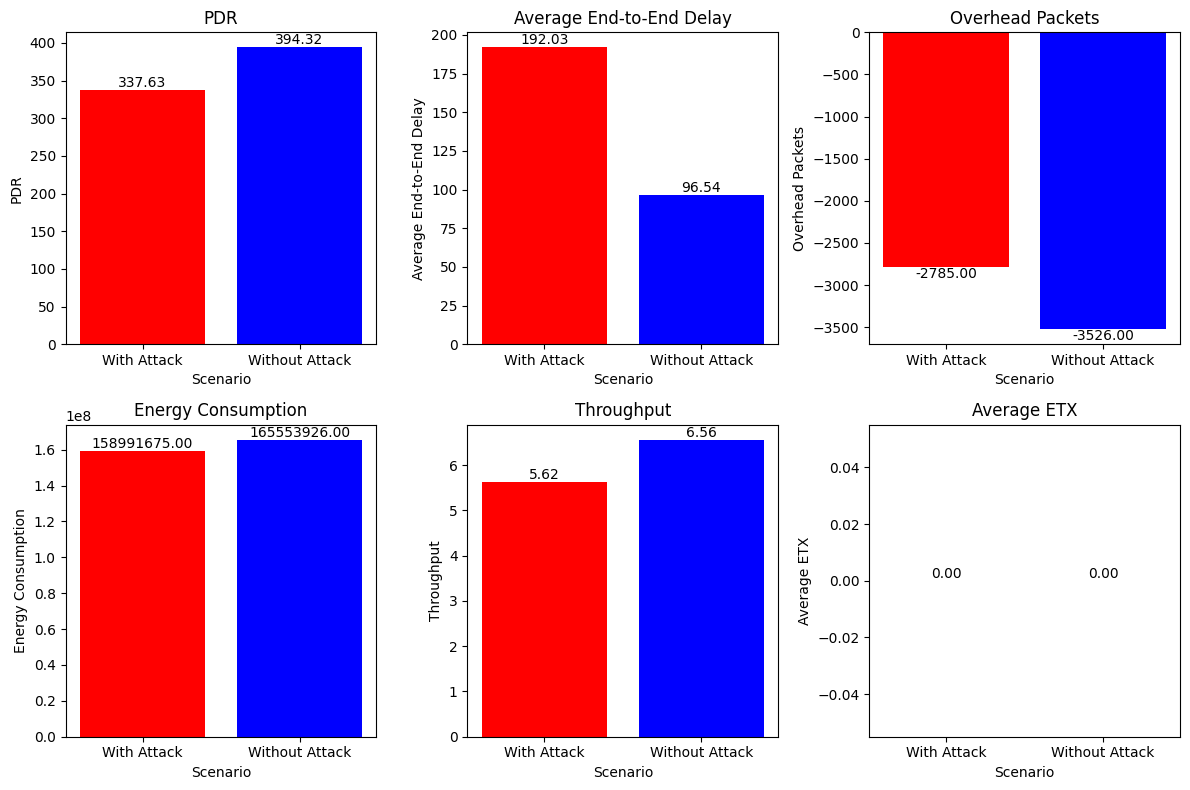

In [5]:
# Plot results
metrics = ["PDR", "Average End-to-End Delay", "Overhead Packets",
           "Energy Consumption", "Throughput", "Average ETX"]

data = {
    "With Attack": after_attack,
    "Without Attack": before_attack
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    values = [data["With Attack"][metric], data["Without Attack"][metric]]
    axes[idx].bar(["With Attack", "Without Attack"], values, color=["red", "blue"])
    axes[idx].set_title(metric)
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlabel("Scenario")
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()